# Import Necessary Libraries

In [1]:
!pip install nibabel tifffile keras keras-core tensorflow


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical # multiclass semantic segmentation, therefore the volumes to categorical
import matplotlib.pyplot as plt
from tifffile import imsave
from sklearn.preprocessing import MinMaxScaler #scale values
import tensorflow as tf
import random
import os.path
!pip install split-folders
!pip3 install -U segmentation-models-3D
import splitfolders
!pip install -q -U keras-tuner

2024-03-22 22:25:42.727323: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 22:25:43.760616: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
# To always ensure that the GPU is available
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2024-03-22 22:25:58.026890: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-22 22:25:58.056760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-22 22:25:58.057045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Define the MinMax Scaler + Data from S3

* The MinMax scaler is necessary for transforming the scans' features to a range between 0 and 1

In [4]:
scaler = MinMaxScaler()

from os import environ, listdir, path, unlink
from shutil import rmtree

from boto3 import client


def ingest_data(bucket_name='', data_folder='./data'):
    _clean_folder(data_folder)

    print('Commencing data ingestion.')

    s3_endpoint_url = environ.get('AWS_S3_ENDPOINT')
    s3_access_key = environ.get('AWS_ACCESS_KEY_ID')
    s3_secret_key = environ.get('AWS_SECRET_ACCESS_KEY')
    s3_bucket_name = environ.get('AWS_S3_BUCKET')

    print(f'Downloading data from bucket "{s3_bucket_name}" '
          f'from S3 storage at {s3_endpoint_url}')

    s3_client = client(
        's3', endpoint_url=s3_endpoint_url,
        aws_access_key_id=s3_access_key, aws_secret_access_key=s3_secret_key
    )

    paginator = s3_client.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=s3_bucket_name)

    for page in pages:
        for obj in page.get('Contents', []):
            key = obj['Key']
            if key.endswith('.nii'):
                local_file_path = path.join(data_folder, key.split('/')[-1])

                print(f'Downloading {key} to {local_file_path}')
                s3_client.download_file(
                    s3_bucket_name, key, local_file_path
                )

    print('Finished data ingestion.')


def _clean_folder(folder):
    print(f'Cleaning folder {folder}')

    for filename in listdir(folder):
        file_path = path.join(folder, filename)
        try:
            if path.isfile(file_path) or path.islink(file_path):
                unlink(file_path)
            elif path.isdir(file_path):
                rmtree(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')


if __name__ == '__main__':
    ingest_data(data_folder='./data')

Cleaning folder ./data
Commencing data ingestion.
Finished data ingestion.


# Load sample images and visualize



In [5]:
DATASET_PATH = 'ingested_data/'

test_image_flair = nib.load(DATASET_PATH + 'flair.nii').get_fdata()
print(test_image_flair[156][98][78])
test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)
print(test_image_flair[156][98][78])

test_image_t1 = nib.load(DATASET_PATH + 't1.nii').get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce = nib.load(DATASET_PATH + 't1ce.nii').get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2 = nib.load(DATASET_PATH + 't2.nii').get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask = nib.load(DATASET_PATH + 'seg.nii').get_fdata()
test_mask = test_mask.astype(np.uint8)

print(np.unique(test_mask))
# Reassign label value 4 to 3
test_mask[test_mask==4] = 3
print(np.unique(test_mask))

900.0
0.45615813482007095
[0 1 2 4]
[0 1 2 3]


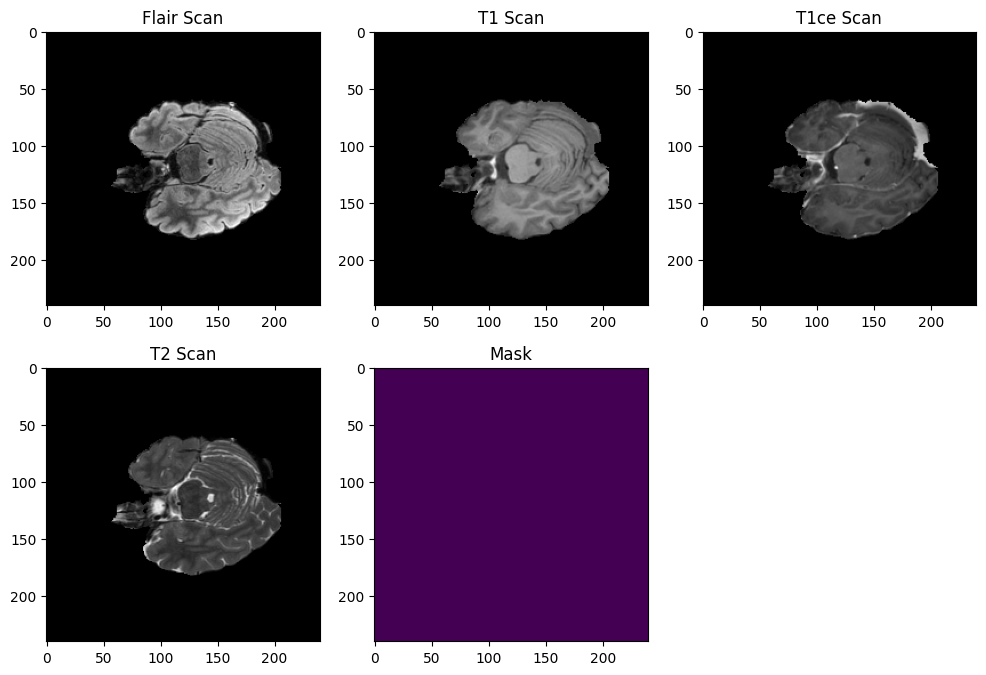

In [6]:
n_slice = random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(test_image_flair[:, :, n_slice], cmap='gray')
plt.title('Flair Scan')

plt.subplot(232)
plt.imshow(test_image_t1[:, :, n_slice], cmap='gray')
plt.title('T1 Scan')

plt.subplot(233)
plt.imshow(test_image_t1ce[:, :, n_slice], cmap='gray')
plt.title('T1ce Scan')

plt.subplot(234)
plt.imshow(test_image_t2[:, :, n_slice], cmap='gray')
plt.title('T2 Scan')

plt.subplot(235)
plt.imshow(test_mask[:, :, n_slice])
plt.title('Mask')

plt.show()



# Data Processing: Combining the volumes of scans to one + Cropping the scans and masks

*   The numpy array is reshaped to 2D, the dimensions the scaler can take as input, the array is transformed and then reshaped back to 3D
*   Result: the feature at position [156][98][78] of the loaded FLAIR scan numpy array is transformed from 1920.0 to 0.7683...
* The three scans to be used are stacked together to forme a combined scan.
* Result: A FLAIR scan, a T1CE scan and a T2 scan, all of dimensions 255 x 255 x 155 are stacked to form a combined scan of dimensions 255 x 255 x 155 x 3
* The combined scan is cropped to 128 x 128 x 128 x 3
* Label 4 in the dataset is reassigned to label 3 resulting to a continuous list of labels: 0, 1, 2, 3

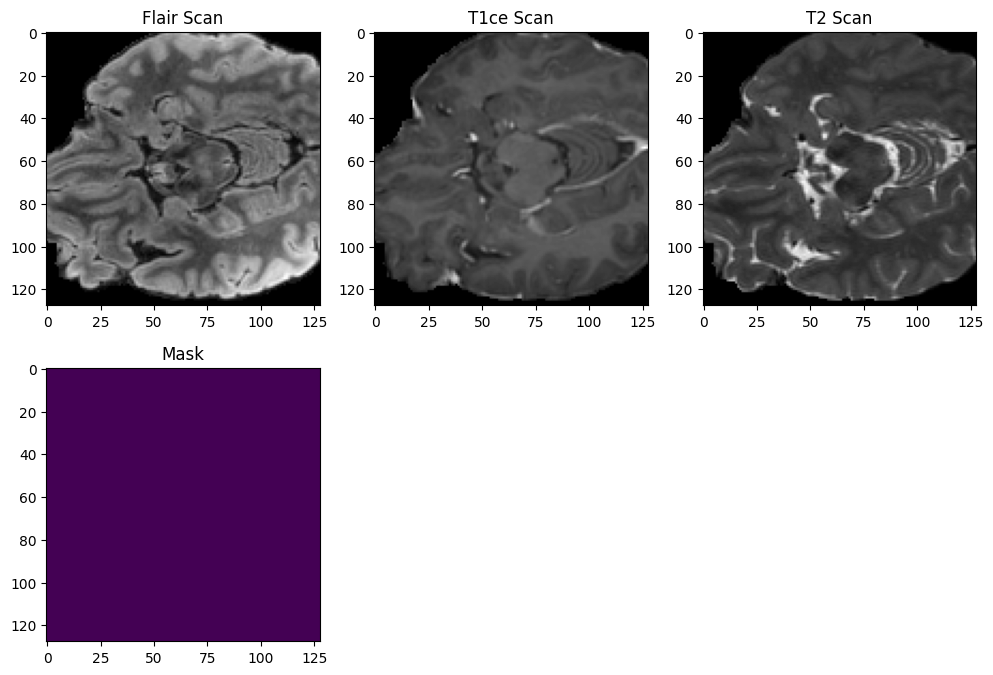

In [7]:
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)
combined_x = combined_x[56:184, 56:184, 13:141] #crop to 128 x 128 x 128 X 3

test_mask = test_mask[56:184, 56:184, 13:141]
n_slice = random.randint(0, test_mask.shape[1])
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(combined_x[:, :, n_slice, 0], cmap='gray')
plt.title('Flair Scan')

plt.subplot(232)
plt.imshow(combined_x[:, :, n_slice, 1], cmap='gray')
plt.title('T1ce Scan')

plt.subplot(233)
plt.imshow(combined_x[:, :, n_slice, 2], cmap='gray')
plt.title('T2 Scan')

plt.subplot(234)
plt.imshow(test_mask[:, :, n_slice])
plt.title('Mask')

plt.show()

In [8]:
from tensorflow.keras import backend as K

print(K.int_shape(test_image_flair))

print(K.int_shape(combined_x))

(240, 240, 155)
(128, 128, 128, 3)


In [9]:
flair_list = sorted(glob.glob(DATASET_PATH + '*/flair.nii'))
t1_list = sorted(glob.glob(DATASET_PATH + '*/t1.nii'))
t1ce_list = sorted(glob.glob(DATASET_PATH + '*/t1ce.nii'))
t2_list = sorted(glob.glob(DATASET_PATH + '*/t2.nii'))
mask_list = sorted(glob.glob(DATASET_PATH + '*/seg.nii'))


for img in range(len(flair_list)):
  print('Now processing image and masks no: ', img)

  temp_image_flair = nib.load(flair_list[img]).get_fdata()
  temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

  temp_image_t1 = nib.load(t1_list[img]).get_fdata()
  temp_image_t1 = scaler.fit_transform(temp_image_t1.reshape(-1, temp_image_t1.shape[-1])).reshape(temp_image_t1.shape)

  temp_image_t1ce = nib.load(t1ce_list[img]).get_fdata()
  temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

  temp_image_t2 = nib.load(t2_list[img]).get_fdata()
  temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

  temp_mask = nib.load(mask_list[img]).get_fdata()
  temp_mask = temp_mask.astype(np.uint8)
  temp_mask[temp_mask == 4] = 3

  temp_combined_images = np.stack([temp_image_flair, temp_image_t1, temp_image_t1ce, temp_image_t2], axis = 3)
  temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
  temp_mask = temp_mask[56:184, 56:184, 13:141]

  val, counts = np.unique(temp_mask, return_counts=True)

  if(1 - (counts[0]/counts.sum())) > 0.01:
    temp_mask = to_categorical(temp_mask, num_classes=4)
    np.save(DATASET_PATH + 'final_dataset/scans/image_' + str(img) + '.npy', temp_combined_images)
    np.save(DATASET_PATH + 'final_dataset/masks/image_' + str(img) + '.npy', temp_mask)
    print("Saved")
  else:
    print("Not saved")

Now processing image and masks no:  0
Saved


# Dataset Splitting: 60:20:20 for train, val and test

In [10]:
input_folder = DATASET_PATH + 'final_dataset/'
output_folder = DATASET_PATH + 'split_dataset/'
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.6, .2, .2), group_prefix=None)

Copying files: 2 files [00:00,  6.26 files/s]


# Data Generator




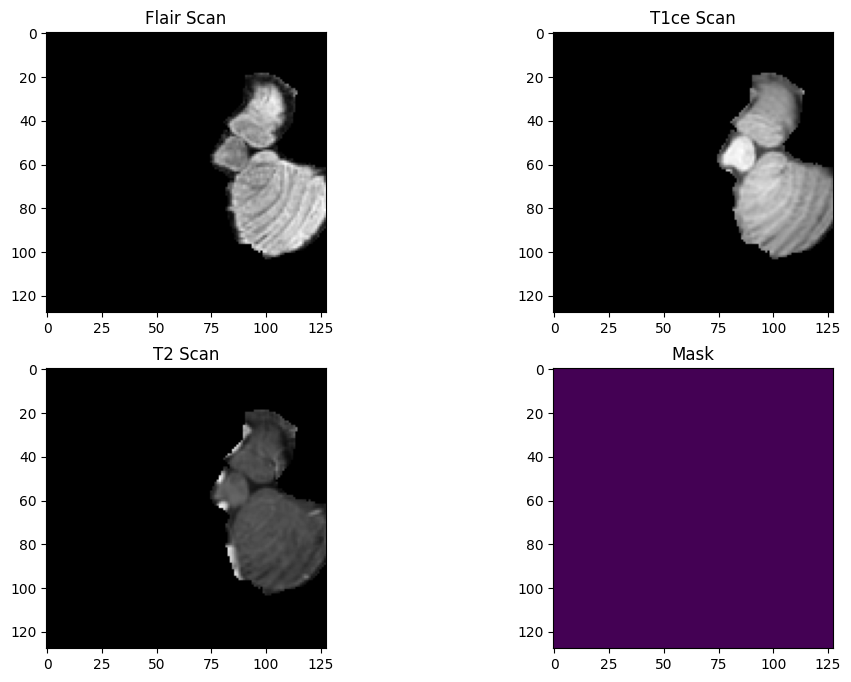

In [11]:
import os
import numpy as np

def load_img(img_dir, img_list):
  images=[]
  for i, image_name in enumerate(img_list):
    if(image_name.split('.')[1] == 'npy'):
      image = np.load(img_dir + image_name)
      images.append(image)
    images = np.array(images)
    return images

def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
  L = len(img_list)
  # keras needs the generator infinite, so use while True
  while True:
    batch_start = 0
    batch_end = batch_size

    while batch_start < L:
      limit = min(batch_end, L)
      X = load_img(img_dir, img_list[batch_start:limit])
      Y = load_img(mask_dir, mask_list[batch_start:limit])

      yield(X, Y) # a tuple with two numpy arrays with batch_size samples

      batch_start += batch_size
      batch_end += batch_size


# Test the generator
TRAIN_DATASET_PATH = 'ingested_data/final_dataset/'
train_img_dir = TRAIN_DATASET_PATH + 'scans/'
train_mask_dir = TRAIN_DATASET_PATH + 'masks/'

train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

# Verify generator - In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0, img.shape[0]-1)

test_img = img[img_num]
test_mask = msk[img_num]
test_mask = np.argmax(test_mask, axis=3)

n_slice = random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12,8))

plt.subplot(221)
plt.imshow(test_img[:, :, n_slice, 0], cmap='gray')
plt.title('Flair Scan')

plt.subplot(222)
plt.imshow(test_img[:, :, n_slice, 1], cmap='gray')
plt.title('T1ce Scan')

plt.subplot(223)
plt.imshow(test_img[:, :, n_slice, 2], cmap='gray')
plt.title('T2 Scan')

plt.subplot(224)
plt.imshow(test_mask[:, :, n_slice])
plt.title('Mask')

plt.show()

# Define image generators for training, validation and testing

In [12]:
DATASET_PATH = 'ingested_data/split_dataset/'
train_img_dir = DATASET_PATH + 'train/scans/'
train_mask_dir = DATASET_PATH + 'train/masks/'

val_img_dir = DATASET_PATH + 'val/scans/'
val_mask_dir = DATASET_PATH + 'val/masks/'

test_img_dir = DATASET_PATH + 'test/scans/'
test_mask_dir = DATASET_PATH + 'test/masks/'

train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

test_img_list = os.listdir(test_img_dir)
test_mask_list = os.listdir(test_mask_dir)

batch_size = 2
train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

test_img_datagen = imageLoader(test_img_dir, test_img_list,
                                test_mask_dir, test_mask_list, batch_size)


# Losses and metrics
* These losses and metrics best handle the problem of class imbalance
* Used: dice_coef as a metric, tversky_loss as a loss

In [13]:
import tensorflow.keras.backend as K


def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) +
                                           smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg +
                                  (1 - alpha) * false_pos + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

# Define loss, metrics and optimizer to be used for training

In [14]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, Activation, add, concatenate, Conv3DTranspose, BatchNormalization, Dropout, UpSampling3D, multiply
from tensorflow.keras.optimizers import Adam
from keras import layers

kernel_initializer = 'he_uniform'

import segmentation_models_3D as sm

metrics = [dice_coef]

LR = 0.0001
optim = Adam(LR)

steps_per_epoch = len(train_img_list) // batch_size
val_steps_per_epoch = len(val_img_list) // batch_size

Segmentation Models: using `tf.keras` framework.


2024-03-22 22:26:04.180856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-22 22:26:04.181181: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-22 22:26:04.181412: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# 3D UNet Model

In [15]:
def UNet(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))

  # Downsampling
  c1 = Conv3D(filters = 16, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(inputs)
  c1 = Dropout(0.1)(c1)
  c1 = Conv3D(filters = 16, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
  p1 = MaxPooling3D((2, 2, 2))(c1)

  c2 = Conv3D(filters = 32, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
  c2 = Dropout(0.1)(c2)
  c2 = Conv3D(filters = 32, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
  p2 = MaxPooling3D((2, 2, 2))(c2)

  c3 = Conv3D(filters = 64, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv3D(filters = 64, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
  p3 = MaxPooling3D((2, 2, 2))(c3)

  c4 = Conv3D(filters = 128, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv3D(filters = 128, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
  p4 = MaxPooling3D((2, 2, 2))(c4)

  c5 = Conv3D(filters = 256, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
  c5 = Dropout(0.3)(c5)
  c5 = Conv3D(filters = 256, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
  
  # Upsampling part
  u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv3D(filters = 128, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv3D(filters = 128, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)  
    
  u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv3D(filters = 64, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv3D(filters = 64, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)  
  
  u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv3D(filters = 32, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
  c8 = Dropout(0.1)(c8)
  c8 = Conv3D(filters = 32, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)  

  u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1])
  c9 = Conv3D(filters = 16, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
  c9 = Dropout(0.1)(c9)
  c9 = Conv3D(filters = 16, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)  

  outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  model.summary()

  return model

# Test the working of the 3D UNet model

In [16]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

model = UNet(IMG_HEIGHT = 128,
              IMG_WIDTH = 128,
              IMG_DEPTH = 128,
              IMG_CHANNELS = 3,
              num_classes = 4)

model.compile(optimizer = optim, loss = tversky_loss, metrics = metrics)

print(model.summary)

print(model.input_shape)
print(model.output_shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 128, 3)]   0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 128, 128, 128, 16)    1312      ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 128, 16)    0         ['conv3d[0][0]']              
                                                                                                  
 conv3d_1 (Conv3D)           (None, 128, 128, 128, 16)    6928      ['dropout[0][0]']             
                                                                                              

# 3D Attention UNet Model

# Test the working of a 3D Attention UNet Model

In [17]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

model = UNet(IMG_HEIGHT = 128,
              IMG_WIDTH = 128,
              IMG_DEPTH = 128,
              IMG_CHANNELS = 3,
              num_classes = 4)

model.compile(optimizer = optim, loss = tversky_loss, metrics = metrics)

print(model.summary)

print(model.input_shape)
print(model.output_shape)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 128, 3)]   0         []                            
                                                                                                  
 conv3d_19 (Conv3D)          (None, 128, 128, 128, 16)    1312      ['input_2[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 128, 128, 128, 16)    0         ['conv3d_19[0][0]']           
                                                                                                  
 conv3d_20 (Conv3D)          (None, 128, 128, 128, 16)    6928      ['dropout_9[0][0]']           
                                                                                            

# Fit the Model

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TerminateOnNaN

checkpoint_path = ''
log_path = ''

callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, verbose=1),
    ReduceLROnPlateau(factor=0.1,
                      monitor='val_loss',
                      patience=4,
                      min_lr=0.0001,
                      verbose=1,
                      mode='min'),
    ModelCheckpoint(checkpoint_path,
                    monitor='val_loss',
                    mode='min',
                    verbose=0,
                    save_best_only=True),
    CSVLogger(log_path, separator=',', append=True),
    TerminateOnNaN()
]

history = model.fit(train_img_datagen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=100,
                    verbose=1,
                    validation_data=val_img_datagen,
                    validation_steps=val_steps_per_epoch,
                    callbacks=callbacks
                    )

history_callback = np.save('', history.history)

# Load Model for more training

In [ ]:
import tensorflow.keras.models as load
import keras
model = load.load_model('', custom_objects={
    'tversky_loss': tversky_loss,
    'dice_coef': dice_coef
})

checkpoint_path = ''
log_path = ''

callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, verbose=1),
    ReduceLROnPlateau(factor=0.1,
                      monitor='val_loss',
                      patience=4,
                      min_lr=0.0001,
                      verbose=1,
                      mode='min'),
    ModelCheckpoint(checkpoint_path,
                    monitor='val_loss',
                    mode='min',
                    verbose=0,
                    save_best_only=True),
    CSVLogger(log_path, separator=',', append=True),
    TerminateOnNaN()
]

history = model.fit(train_img_datagen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=100,
                    verbose=1,
                    validation_data=val_img_datagen,
                    validation_steps=val_steps_per_epoch,
                    callbacks=callbacks
                    )

history_callback = np.save('', history.history)

# Plot the training and validation loss (tversky) and dice coefficient (metric) at each epoch

In [ ]:
history = np.load('',allow_pickle='TRUE').item()

print(history)
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history['dice_coef']
val_acc = history['val_dice_coef']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Trainign and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Model Evaluation

In [ ]:
from tensorflow.keras.models import load_model
my_model = load_model('', custom_objects={
    'tversky_loss': tversky_loss,
    'dice_coef': dice_coef},
    compile = True)

# Verify IoU on a batch of images from the test dataset
batch_size = 8
test_img_datagen = imageLoader(val_img_dir, val_img_list,
                               val_mask_dir, val_mask_list, batch_size)

test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)

results = my_model.evaluate(test_image_batch, test_mask_batch, batch_size=batch_size)
print("test acc, test loss:", results)

# Predict on a test scan

In [ ]:
from tensorflow.keras.models import load_model
my_model = load_model('', compile=False)

img_num = 53
test_scan = np.load('' + str(img_num) + '.npy')

test_mask = np.load('' + str(img_num) + '.npy')
test_mask_argmax = np.argmax(test_mask, axis = 3)

test_scan_input = np.expand_dims(test_scan, axis = 0)
test_prediction = my_model.predict(test_scan_input)
test_prediction_argmax = np.argmax(test_prediction, axis = 4)[0, :, :, :]

In [ ]:
# n_slice = 55
n_slice = random.randint(0, test_mask_argmax.shape[2])

plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(test_scan[:, :, n_slice, 1], cmap='gray')
plt.title('Testing Scan')

plt.subplot(232)
plt.imshow(test_mask_argmax[:, :, n_slice])
plt.title('Testing Label')

plt.subplot(235)
plt.imshow(test_prediction_argmax[:, :, n_slice])
plt.title('Prediction on test image')

plt.show()